In [1]:
# Attempting to recover training data using model's parameters and a DCGAN that was trained on similar data
# Author: Suraj Neupane
# Written from scratch as a part of a Research Project 2025, Concordia University of Edmonton.
import numpy as np

import torch
from torch import nn
from torch.nn import functional

from torch.utils import data
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.__version__

'2.5.1+cu118'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
# DCGAN Implementation Class
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input shape: img_channels x 64 x 64
            nn.Conv2d(
              in_channels=img_channels, out_channels=features_d, kernel_size=4, stride=2, padding=1
            ), # Output shape: features_d x 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # Output shape: features_d*2 x 16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1), # Output shape: features_d*4 x 8 x 8
            self._block(features_d*4, features_d*8, 4, 2, 1), # Output shape: features_d*8 x 4 x 4
           
            nn.Conv2d(in_channels=features_d*8, out_channels=1, kernel_size=4, stride=2, padding=0), # Output shape: 1 x 1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, X):
        return self.disc(X)


In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0), # z_dim: (batch_size, 100, 1, 1) -> (batch_size, 1024, 4, 4)
            self._block(features_g*16, features_g*8, 4, 2, 1), # z_dim: (batch_size, 1024, 4, 4) -> (batch_size, 512, 8, 8)
            self._block(features_g*8, features_g*4, 4, 2, 1), # z_dim: (batch_size, 512, 8, 8) -> (batch_size, 256, 16, 16)
            self._block(features_g*4, features_g*2, 4, 2, 1), # z_dim: (batch_size, 128, 16, 16) -> (batch_size, 64, 32, 32)
            nn.ConvTranspose2d(
                in_channels=features_g*2, out_channels=img_channels, kernel_size=4, stride=2, padding=1 # z_dim: (batch_size, 64, 32, 32) -> (batch_size, 1, 64, 64)
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, X):
        return self.gen(X)

In [7]:
# Hyperparams
z_dim = 100
img_channels = 1
features_disc = 64
features_gen = 64

In [8]:
# Create the model instances
gen = Generator(z_dim, img_channels, features_gen).to(device)
disc = Discriminator(img_channels, features_disc).to(device)

In [9]:
# Load the trained GAN
gen.load_state_dict(torch.load('saved models/Generator.pth', weights_only=True))
disc.load_state_dict(torch.load('saved models/Discriminator.pth', weights_only=True))

<All keys matched successfully>

In [10]:
# Generate a random fake image
noise = torch.randn(1, z_dim, 1, 1).to(device)
fake_img = gen(noise)

In [11]:
fake_img.shape

torch.Size([1, 1, 64, 64])

torch.Size([64, 64])


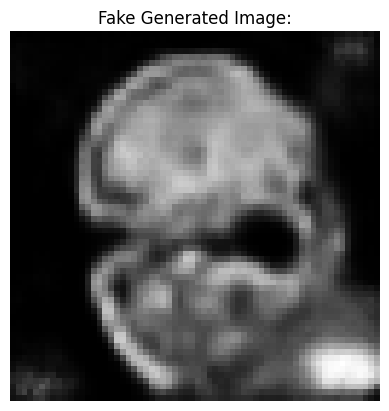

In [12]:
fake_img = fake_img.squeeze()
print(fake_img.shape)
plt.axis(False)
plt.title('Fake Generated Image:')
plt.imshow(fake_img.cpu().detach(), cmap='gray')

In [13]:
# Target Model
class TFCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            Reshape(),
        )

        self.h_size = 64 * 4 * 4

        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(True),
            nn.Linear(128, n_classes)
        )

    def forward(self, xs):
        code = self.encoder(xs)
        logits = self.classifier(code)
        return code, logits


In [14]:
class Reshape(nn.Module):
    def __init__(self,):
        super().__init__()

    def forward(self, xs):
        return xs.reshape((xs.shape[0], -1))

In [15]:
class ClassifyNet(nn.Module):
    def __init__(self, net, init_way, n_classes, input_size=None):
        super().__init__()
        self.net = net
        self.init_way = init_way
        self.n_classes = n_classes

        model = TFCNN(n_classes)

        self.h_size = model.h_size

        # Convo and pool layers
        self.encoder = model.encoder

        # Classifier layer
        self.classifier = nn.Linear(
            self.h_size, self.n_classes, bias=False
        )

        if self.init_way == "orth":
            ws = get_orth_weights(self.h_size, self.n_classes)
            self.classifier.load_state_dict({"weight": ws})

    def forward(self, xs):
        hs = self.encoder(xs)
        logits = self.classifier(hs)
        return hs, logits

In [16]:
def load_target_model(base_net, n_classes, path):
    # Create the base model
    model = ClassifyNet(net=base_net, init_way='none', n_classes=n_classes)
    # Load the model
    model.load_state_dict(torch.load(path, weights_only=True))

    return model

In [17]:
# Target Model Loading
BASE_NET = 'TFCNN'
DATASET = 'tumor4'
N_CLASSES = 4

target_model = load_target_model(base_net=BASE_NET, n_classes=N_CLASSES, path='saved models/fedavg_global_model.pth').to(device)
print('Model loaded successfully!')
target_model.eval()

num_params = sum(p.numel() for p in target_model.parameters())
print('Number of parameters in the loaded model:', num_params)


Model loaded successfully!
Number of parameters in the loaded model: 60416


In [18]:
# Do Model Inversion
# Define a learnable latent vector
z = torch.randn(1, z_dim, 1, 1, requires_grad=True)  # Start with random noise
z.shape

torch.Size([1, 100, 1, 1])

In [19]:
learning_rate = 0.01
target_class = 1 # The second class

# Create the optimizer
optimizer = torch.optim.Adam([z], lr=learning_rate)

# Loss function (e.g., Cross-Entropy with classifier outputs)
loss_fn = nn.CrossEntropyLoss()
target_class = torch.tensor([target_class])  # Set the target class

In [20]:
# Optimization loop to find the best z
rounds = 1000
for i in range(rounds):
    optimizer.zero_grad()
    
    generated_image = gen(z.to(device))  # Generate an image from the latent vector
    generated_image = generated_image.repeat(1, 3, 1, 1)
    generated_image = functional.interpolate(generated_image, size=(32, 32), mode='nearest')
    #print(generated_image.shape)
    hs, prediction_logits = target_model(generated_image)  # Classifier output
    #print(prediction_logits)
    #print(type(prediction_logits))
    loss = loss_fn(prediction_logits, target_class.to(device))  # Minimize difference with true class
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Step {i}, Loss: {loss.item()}")

Step 0, Loss: 3.285355567932129
Step 50, Loss: 0.5108799934387207
Step 100, Loss: 0.2235725224018097
Step 150, Loss: 0.0898350179195404
Step 200, Loss: 0.04022325202822685
Step 250, Loss: 0.02507328800857067
Step 300, Loss: 0.018940892070531845
Step 350, Loss: 0.014683865942060947
Step 400, Loss: 0.011322646401822567
Step 450, Loss: 0.009055733680725098
Step 500, Loss: 0.007524363696575165
Step 550, Loss: 0.006479800678789616
Step 600, Loss: 0.005514409858733416
Step 650, Loss: 0.004736987873911858
Step 700, Loss: 0.004226561635732651
Step 750, Loss: 0.003874178510159254
Step 800, Loss: 0.003560158656910062
Step 850, Loss: 0.0032458023633807898
Step 900, Loss: 0.0029782960191369057
Step 950, Loss: 0.002762789139524102


In [21]:
# Display the generated image
img = gen(z.to(device)).squeeze(dim=0).squeeze(dim=0)
print(img.shape)

torch.Size([64, 64])


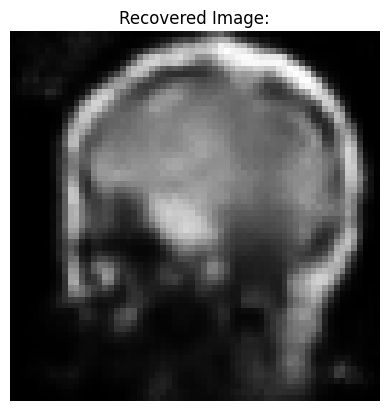

In [22]:
plt.axis(False)
plt.title('Recovered Image:')
plt.imshow(img.cpu().detach(), cmap='gray')

In [ ]:
# Generate a series of recovered images 
# 1. Rotate over the 4 classes randomly 0, 1, 2, 3
# 2. Have a random seed initialization for the latent vector z in every iteration
# 3. Optimize the latent vector and recover a potential training data
# 4. Store each of the recovered images in their own list
